In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# from pykeops.torch import LazyTensor
from sklearn.cluster import KMeans

In [77]:
a = LabelEncoder().fit_transform(['A','B'])
a

array([0, 1], dtype=int64)

In [79]:
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # load the csv file as a dataframe
        df = read_csv(path, header=None)
        # store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        # ensure input data is floats
        self.X = self.X.astype('float32')
        # label encode target and ensure the values are floats
        
        self.y = LabelEncoder().fit_transform(self.y)
        
    
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])
 
# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 16)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(16, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(8, 6)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # output layer
        X = self.hidden3(X)
        X = self.act3(X)
        return X
 
# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl
 
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(500):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
         
            targets =targets.long()
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
 
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc
 
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat
 
# prepare the data
path = 'data_classification.csv'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(15)
# train the model
train_model(train_dl, model)
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)
# make a single prediction
# row = [5.1,3.5,1.4,0.2]
# yhat = predict(row, model)
# print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))

Y:  ['A' 'C' 'C' 'A' 'C' 'C' 'D' 'C' 'A' 'C' 'C' 'C' 'C' 'C' 'A' 'C' 'D' 'A'
 'C' 'C' 'A' 'B' 'B' 'C' 'C' 'D' 'C' 'A' 'E' 'C' 'E' 'A' 'B' 'D' 'D' 'B'
 'D' 'A' 'A' 'C' 'A' 'C' 'C' 'B' 'C' 'C' 'A' 'C' 'B' 'C' 'C' 'A' 'D' 'D'
 'C' 'D' 'C' 'C' 'B' 'B' 'C' 'B' 'A' 'C' 'B' 'C' 'C' 'A' 'B' 'A' 'C' 'A'
 'C' 'A' 'C' 'C' 'A' 'C' 'C' 'B' 'C' 'C' 'C' 'B' 'C' 'D' 'A' 'B' 'C' 'C'
 'C' 'A' 'D' 'B' 'C' 'C' 'B' 'C' 'C' 'C' 'C' 'A' 'B' 'A' 'C' 'C' 'A' 'C'
 'C' 'C' 'A' 'A' 'D' 'D' 'C' 'C' 'C' 'A' 'D' 'C' 'B' 'C' 'D' 'C' 'C' 'D'
 'B' 'C' 'B' 'C' 'C' 'C' 'C' 'A' 'A' 'C' 'C' 'C' 'C' 'B' 'D' 'C' 'D' 'B'
 'C' 'E' 'B' 'C' 'C' 'B' 'E' 'B' 'C' 'C' 'B' 'C' 'A' 'D' 'C' 'C' 'B' 'B'
 'A' 'B' 'C' 'A' 'B' 'C' 'D' 'C' 'A' 'B' 'C' 'C' 'C' 'C' 'B' 'C' 'A' 'A'
 'C' 'C' 'A' 'C' 'C' 'E' 'C' 'A' 'D' 'C' 'C' 'B' 'C' 'A' 'A' 'C' 'C' 'A'
 'B' 'A' 'C' 'C' 'A' 'B' 'A' 'A' 'A' 'E' 'C' 'B' 'A' 'C' 'A' 'D' 'C' 'C'
 'C' 'C' 'A' 'C' 'B' 'E' 'C' 'A' 'B' 'A' 'A' 'D' 'C' 'A' 'B' 'B' 'B' 'B'
 'D' 'C' 'E' 'A' 'A' 'B' 'A' 'A' 'A' 'C' 'B' 'A

In [128]:
# atms	banks	churches	gas_stations	hospitals	mosques	pharmacies	restaurants	schools	Males	Females	Children	Working	Elderly	rating	competitors
# atms,banks,bus_stations,churches,gas_stations,hospitals,mosques,pharmacies,restaurants,schools,train_stations,Males,Females,Children,Working,Elderly
# mean rating,4.144363636363636
# std rating,0.9918956913040559
# torch.save(model, 'classification_model.h5')
model = torch.load('classification_model.h5')
def predict(row, model):
    # convert row to data
    row = Tensor(row)
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat
test_values = torch.tensor([1,9,7,3,3,0,2,28,4,145225,163770,75491,225517,7987,20])
mean = pd.read_csv('mean.csv',header = None, index_col = 0, squeeze = True)
std = pd.read_csv('std.csv',header = None, index_col = 0, squeeze = True)
test_values=(test_values-mean)/std
rate = (5-argmax(predict(test_values, model)))
print(rate)

# row = [-0.41819307533039685,0.5821926671373284,-0.6746119390552502,-0.35135535154185005,1.4350276987938648,0.24070553655706434,0.43711593326423953,1.0345962262525923,-0.17080700910291624,-0.8550445939386623,-0.8052269314244348,-0.9926077113988568,-0.7638111533961562,0.20977679943120997,0.7605986154438428]
# # # -4.032392902775001
# yhat = predict(row, model)
# print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))

ValueError: Length of values (1) does not match length of index (15)

In [19]:
#Read Data, Drop unnecessary column and change - in rating to -1
supermarkets = pd.read_csv('supermarkets_cleaned_with_popn_v3.csv')
supermarkets.drop('Unnamed: 0', axis=1, inplace=True)
supermarkets.loc[supermarkets['rating']=='-', 'rating'] = -1
# supermarkets.loc[supermarkets['rating']=='0.0', 'rating'] = -1
supermarkets.rating = supermarkets.rating.map(float)
# supermarkets.head()

In [80]:
df = supermarkets[['atms','banks','churches','gas_stations','hospitals','mosques','pharmacies','restaurants','schools', 'Males', 'Females','Children','Working','Elderly','competitors_supermarket','competitors_shopping_mall','rating']]
	# 'banks','churches','gas_stations','hospitals','mosques','pharmacies','restaurants','schools', 'Males', 'Females','Children','Working','Elderly','new_rating','competitors_supermarket','competitors_shopping_mall','rating']
df.head()

,atms,banks,churches,gas_stations,hospitals,mosques,pharmacies,restaurants,schools,Males,Females,Children,Working,Elderly,competitors_supermarket,competitors_shopping_mall,rating
0,1,9,7,3,3,0,2,28,4,145225,163770,75491,225517,7987,4,6,-1.0
1,8,36,15,1,18,4,9,105,28,161592,185072,83403,251219,12042,19,21,5.0
2,0,15,9,2,2,9,6,54,20,129396,138228,61641,195556,10427,8,3,-1.0
3,1,27,11,1,6,0,13,153,27,145225,163770,75491,225517,7987,35,19,-1.0
4,1,34,22,6,18,1,9,110,21,145225,163770,75491,225517,7987,16,24,-1.0


,atms,banks,churches,gas_stations,hospitals,mosques,pharmacies,restaurants,schools,Males,Females,Children,Working,Elderly,competitors_supermarket,competitors_shopping_mall,rating
atms,1.000000,0.828135,0.305415,0.368077,0.370295,0.058749,0.519521,0.754694,0.332037,-0.190513,-0.165073,-0.241199,-0.148146,0.032817,0.329830,0.606725,0.097199
banks,0.828135,1.000000,0.531843,0.528113,0.653415,0.172386,0.689259,0.865436,0.567052,-0.280568,-0.255651,-0.369762,-0.224740,0.152601,0.576905,0.766280,0.064941
churches,0.305415,0.531843,1.000000,0.288876,0.698704,-0.015786,0.351300,0.386575,0.763857,-0.156311,-0.122850,-0.217462,-0.108113,0.185740,0.426019,0.261948,-0.003244
gas_stations,0.368077,0.528113,0.288876,1.000000,0.311197,0.444005,0.550647,0.368582,0.345861,-0.405302,-0.419968,-0.478415,-0.390894,0.213494,0.091223,0.438721,0.029394
hospitals,0.370295,0.653415,0.698704,0.311197,1.000000,0.097089,0.432480,0.585176,0.701049,-0.229817,-0.208538,-0.297494,-0.187294,0.159509,0.572268,0.470150,-0.013881
mosques,0.058749,0.172386,-0.015786,0.444005,0.097089,1.000000,0.436342,0.159633,0.184863,-0.009352,-0.070497,-0.059165,-0.042234,0.256417,-0.024200,0.414670,-0.001941
pharmacies,0.519521,0.689259,0.351300,0.550647,0.432480,0.436342,1.000000,0.728297,0.510859,-0.218318,-0.214067,-0.314816,-0.176793,0.206426,0.531105,0.703419,0.022476
restaurants,0.754694,0.865436,0.386575,0.368582,0.585176,0.159633,0.728297,1.000000,0.504404,-0.178344,-0.155207,-0.271786,-0.120255,0.119902,0.722186,0.830335,0.061098
schools,0.332037,0.567052,0.763857,0.345861,0.701049,0.184863,0.510859,0.504404,1.000000,-0.183357,-0.168946,-0.260758,-0.144110,0.237100,0.451237,0.350692,0.003909
Males,-0.190513,-0.280568,-0.156311,-0.405302,-0.229817,-0.009352,-0.218318,-0.178344,-0.183357,1.000000,0.993548,0.978676,0.991665,0.477228,-0.047794,-0.189303,-0.003069


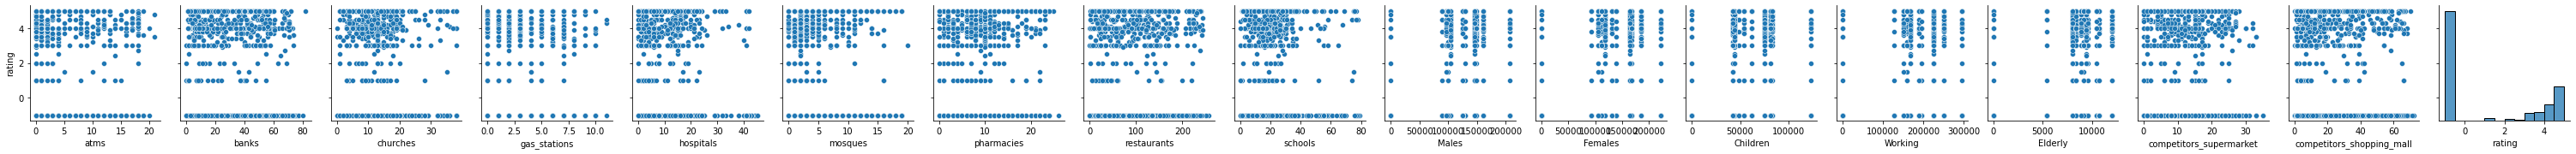

In [36]:
sns.pairplot(df, y_vars='rating')
df.corr()

In [88]:
#get rid of <0 ratings
# len(df)
# old_df = df
df = old_df
df = df.drop(df.index[df['rating'] <=0])
df['competitors'] = df['competitors_supermarket'] + df['competitors_shopping_mall']
df.drop(columns=['competitors_supermarket','competitors_shopping_mall'],inplace= True)
len(df)

550

In [99]:
#normalize the data
# mean = df.mean()
# std = df.std()
mean = pd.read_csv('mean.csv',header = None, index_col = 0, squeeze = True)
std = pd.read_csv('std.csv',header = None, index_col = 0, squeeze = True)
# mean = dict(mean)
# mean.to_csv('mean.csv')
# std.to_csv('std.csv')
df1=(df-df.mean())/df.std()
# print('mean: ', mean)
# print('std: ', std)
df1.head()

,atms,banks,churches,gas_stations,hospitals,mosques,pharmacies,restaurants,schools,Males,Females,Children,Working,Elderly,rating,competitors
1,0.632863,0.387775,0.452302,-0.747350,1.065464,-0.011943,0.095376,0.220021,0.519393,0.812946,0.945645,0.677047,0.924225,1.592146,0.862627,0.252146
10,-0.768545,-1.216171,-0.533748,-1.143345,-0.659168,3.777791,-1.100712,-1.142827,-0.477562,2.135148,1.886422,2.395044,1.820708,0.269120,0.862627,-0.807130
11,-0.418193,-0.584314,0.593167,-0.351355,-0.659168,-0.769890,-1.100712,-0.531895,-0.784318,0.343002,0.391767,0.339766,0.405590,-0.556381,-0.347177,-0.383419
12,0.808039,0.582193,0.170574,1.628618,1.065464,1.503950,0.607986,1.426219,1.362970,-0.979515,-0.945582,-1.085795,-0.909542,0.037577,0.862627,0.591114
16,-0.243017,0.339171,1.156624,1.232624,-0.412792,-0.264592,0.437116,0.345340,0.059260,-0.855045,-0.805227,-0.992608,-0.763811,0.209777,0.358542,0.082662


In [44]:
df.corr()

,atms,banks,churches,gas_stations,hospitals,mosques,pharmacies,restaurants,schools,Males,Females,Children,Working,Elderly,rating,competitors
atms,1.000000,0.855719,0.354136,0.339390,0.429401,0.019342,0.485508,0.782182,0.332048,-0.159120,-0.131931,-0.211371,-0.114120,0.001621,-0.015393,0.632925
banks,0.855719,1.000000,0.499623,0.496545,0.650408,0.139316,0.664035,0.876599,0.506802,-0.244215,-0.219279,-0.333615,-0.188303,0.120211,0.007102,0.805152
churches,0.354136,0.499623,1.000000,0.267520,0.639800,-0.048328,0.347111,0.389913,0.731109,-0.118683,-0.084322,-0.184533,-0.068899,0.198591,-0.031469,0.308318
gas_stations,0.339390,0.496545,0.267520,1.000000,0.292047,0.440817,0.582522,0.328886,0.319952,-0.393052,-0.401177,-0.470549,-0.372866,0.211305,0.021489,0.331908
hospitals,0.429401,0.650408,0.639800,0.292047,1.000000,0.086163,0.457089,0.619769,0.655366,-0.194701,-0.174136,-0.262714,-0.153187,0.149702,0.008673,0.581368
mosques,0.019342,0.139316,-0.048328,0.440817,0.086163,1.000000,0.432606,0.120744,0.146395,-0.012415,-0.072071,-0.058383,-0.045522,0.225638,0.100469,0.279163
pharmacies,0.485508,0.664035,0.347111,0.582522,0.457089,0.432606,1.000000,0.674323,0.516533,-0.220920,-0.216245,-0.317037,-0.180169,0.191837,0.014817,0.680145
restaurants,0.782182,0.876599,0.389913,0.328886,0.619769,0.120744,0.674323,1.000000,0.475496,-0.142679,-0.119422,-0.231530,-0.086362,0.083133,0.001605,0.901890
schools,0.332048,0.506802,0.731109,0.319952,0.655366,0.146395,0.516533,0.475496,1.000000,-0.157000,-0.144965,-0.230981,-0.121424,0.212287,0.008993,0.371412
Males,-0.159120,-0.244215,-0.118683,-0.393052,-0.194701,-0.012415,-0.220920,-0.142679,-0.157000,1.000000,0.993855,0.978625,0.992270,0.492253,0.053814,-0.130273


In [46]:
def generateTarget(df, coefficient):
    data = df
    data['target'] = 0.02 * data['rating'] + 0.6 * data['atms'] + 0.8 *data['banks'] \
              + 0.3 * data['churches'] + 0.3 * data['gas_stations'] + 0.5 *data['hospitals'] \
              + 0.27 * data['mosques'] + 0.68 * data['pharmacies'] + 0.8 *data['restaurants'] \
              + 0.3 * data['schools'] + 0.4 * data['Males'] + 0.5 *data['Females'] \
              + 0.2 * data['Children'] + 0.5 * data['Working'] + 0.3 *data['Elderly'] + 0.6 * data['competitors']
    data.drop('rating', axis=1, inplace=True)
    return data
old_df = df
df = generateTarget(old_df, None)
df.head()

,atms,banks,churches,gas_stations,hospitals,mosques,pharmacies,restaurants,schools,Males,Females,Children,Working,Elderly,competitors,target
1,0.632863,0.387775,0.452302,-0.747350,1.065464,-0.011943,0.095376,0.220021,0.519393,0.812946,0.945645,0.677047,0.924225,1.592146,0.252146,3.569329
10,-0.768545,-1.216171,-0.533748,-1.143345,-0.659168,3.777791,-1.100712,-1.142827,-0.477562,2.135148,1.886422,2.395044,1.820708,0.269120,-0.807130,-0.252443
11,-0.418193,-0.584314,0.593167,-0.351355,-0.659168,-0.769890,-1.100712,-0.531895,-0.784318,0.343002,0.391767,0.339766,0.405590,-0.556381,-0.383419,-2.392650
12,0.808039,0.582193,0.170574,1.628618,1.065464,1.503950,0.607986,1.426219,1.362970,-0.979515,-0.945582,-1.085795,-0.909542,0.037577,0.591114,3.239098
16,-0.243017,0.339171,1.156624,1.232624,-0.412792,-0.264592,0.437116,0.345340,0.059260,-0.855045,-0.805227,-0.992608,-0.763811,0.209777,0.082662,-0.049604


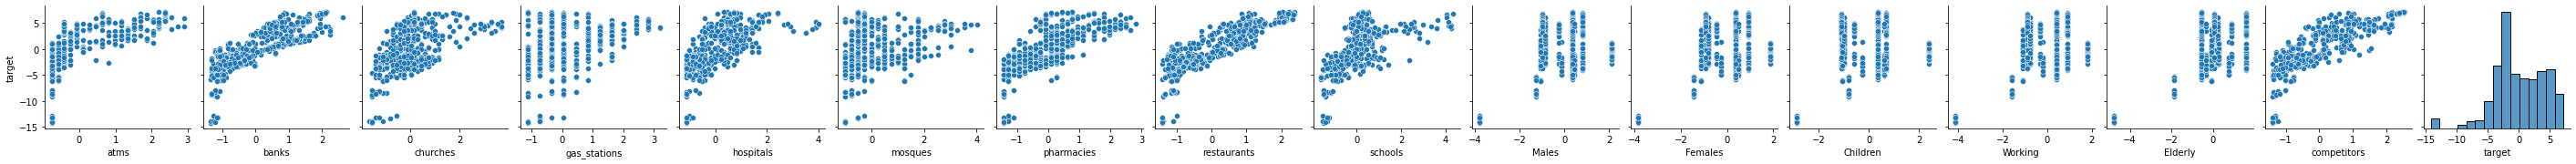

In [48]:
sns.pairplot(df, y_vars='target')

In [62]:
#change the target from number to grade
print('STD: ', df.target.std())
print('mean: ', df.target.mean())
print('median: ', df.target.median()) 
print('min: ', df.target.min())
print('max: ', df.target.max())
grades = {'A':3, 'B':0, 'C': -4, 'D': - 8, 'E':-14, 'F':-100}

STD:  4.078122877649664
mean:  1.6148698540002277e-16
median:  -0.5203580356310672
min:  -14.18430713485476
max:  7.239654931348573


In [63]:
df['grade'] = 'F'
for i, row in df.iterrows():
    ifor_val = -1
    if row['target'] > grades['A']:
        ifor_val = 'A'
    elif row['target'] > grades['B']:
        ifor_val = 'B'
    elif row['target'] > grades['C']:
        ifor_val = 'C'
    elif row['target'] > grades['D']:
        ifor_val = 'D'
    elif row['target'] > grades['E']:
        ifor_val = 'E'
    else:
        ifor_val = 'F'
    df.at[i,'grade'] = ifor_val

In [65]:
df.drop('target', axis=1, inplace=True)
df.to_csv('data_classification.csv',index=False, header=False)

In [112]:
#label the unlabeled data
def get_unlabeled_data(old_df):
    unlabeled_df = old_df.drop(old_df.index[old_df['rating'] >0])  
    mean = pd.read_csv('mean.csv',header = None, index_col = 0, squeeze = True)
    std = pd.read_csv('std.csv',header = None, index_col = 0, squeeze = True) 
    # unlabeled_df=(unlabeled_df- mean)/std
    unlabeled_df.drop('rating',  axis=1, inplace=True)
    return unlabeled_df

x = get_unlabeled_data(old_df).values
x
km = KMeans(n_clusters=5)
yp = km.fit_predict(x)

y = []
grd = {0:''}
for i in yp:
    if i ==0:
        y.a
# supermarkets['predicted_rating'] = yp

array([1, 4, 1, 1, 0, 4, 0, 1, 0, 0, 3, 3, 4, 4, 1, 0, 0, 4, 1, 1, 3, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 3, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 3, 1, 0, 3, 1, 0, 4, 4, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 3, 3, 3, 4, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 3, 1, 0, 0, 1, 1, 4, 0, 0, 3, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 4,
       1, 0, 1, 0, 1, 1, 1, 3, 1, 3, 0, 1, 1, 3, 0, 0, 0, 1, 1, 1, 0, 1,
       3, 1, 1, 1, 1, 1, 4, 1, 3, 1, 0, 0, 0, 0, 1, 4, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 4, 1, 4, 1, 1, 1, 1, 0, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 4, 1, 1, 0, 1, 1, 0, 0, 1, 4, 1, 1,
       0, 0, 4, 1, 0, 1, 1, 0, 4, 0, 0, 3, 0, 1, 1, 1, 0, 0, 3, 0, 1, 1,
       0, 3, 1, 1, 3, 0, 4, 0, 3, 4, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 4, 0, 1, 0, 1, 4, 3, 4, 1,
       1, 1, 0, 4, 4, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,